## Linear Regression Experiments for the thesis: Adaptive Heavy Tailed Stochastic Gradient Descent by Bodu Gong & Dr Pierre Lafaye de Micheaux

Training with SGD:
SGD Epoch 10/100, Loss: 51.9657
SGD Epoch 20/100, Loss: 51.9133
SGD Epoch 30/100, Loss: 51.8772
SGD Epoch 40/100, Loss: 51.8523
SGD Epoch 50/100, Loss: 51.8352
SGD Epoch 60/100, Loss: 51.8235
SGD Epoch 70/100, Loss: 51.8154
SGD Epoch 80/100, Loss: 51.8098
SGD Epoch 90/100, Loss: 51.8059
SGD Epoch 100/100, Loss: 51.8033

Training with AnnealisingOptimiser:
AnnealisingOptimiser Epoch 10/100, Loss: 52.0330
AnnealisingOptimiser Epoch 20/100, Loss: 51.9520
AnnealisingOptimiser Epoch 30/100, Loss: 51.8988
AnnealisingOptimiser Epoch 40/100, Loss: 51.8640
AnnealisingOptimiser Epoch 50/100, Loss: 51.8411
AnnealisingOptimiser Epoch 60/100, Loss: 51.8261
AnnealisingOptimiser Epoch 70/100, Loss: 51.8162
AnnealisingOptimiser Epoch 80/100, Loss: 51.8097
AnnealisingOptimiser Epoch 90/100, Loss: 51.8055
AnnealisingOptimiser Epoch 100/100, Loss: 51.8027


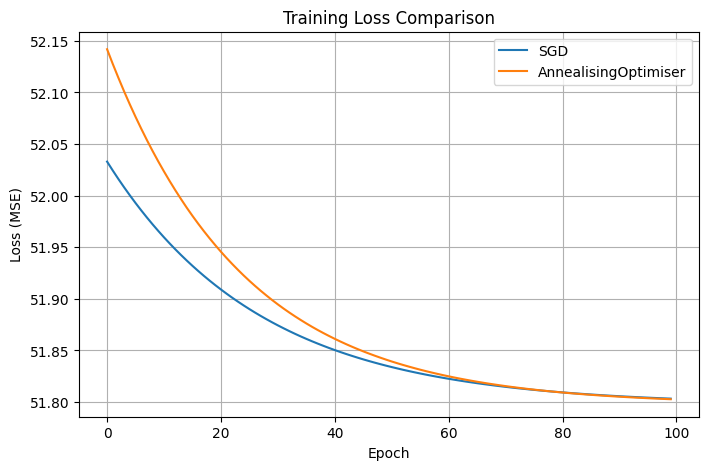

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

CLIP = 10
torch.manual_seed(42)
np.random.seed(42)

class AnnealisingOptimiser(optim.Optimizer):

    """
    A heavy-tailed optimizer that uses a fixed, non-adaptive update.
    The stability parameter alpha increases on each step according to:
         alpha = 2 - exp(- (1/10)*step)
    Noise variance now decays per epoch (instead of per step).

    Additionally, this optimizer stores each noise sample (for later plotting).
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 alpha=1.2,  # initial value; will be updated each step
                 rho=0.05,
                 decay=0.95,
                 noise_init=0.001,
                 noise_decay=0.55,
                 weight_decay=0,
                 **kwargs):

        defaults = dict(
            lr=lr,
            alpha=alpha,
            rho=rho,
            weight_decay=weight_decay
        )
        super(AnnealisingOptimiser, self).__init__(params, defaults)

        self.decay = decay
        self.noise_init = noise_init
        self.noise_decay = noise_decay
        self.beta = 0  # symmetric noise (beta = 0)
        self.num_steps = 1  # count of updates (for alpha update)
        self.current_sigma = noise_init  # current noise scale
        self.noise_samples = []  # to store the noise vectors
        self.epoch = 0  # epoch counter for noise decay

    def update_epoch(self):
        self.epoch += 1

    @torch.no_grad()
    def step(self, closure=None):
        if closure is None:
            raise ValueError("Requires closure for loss computation")
        closure = torch.enable_grad()(closure)
        loss = closure()

        # Update alpha according to: alpha = 2 - exp(- (1/5) * step)
        self.alpha = 2 - math.exp(- (1 / 5) * self.num_steps)

        # Now use step (or epoch) for noise scale decay:
        self.current_sigma = self.noise_init / ((1 + self.num_steps) ** self.noise_decay)

        # Generate heavy-tailed noise for all parameters.
        total_elems = sum(p.numel() for group in self.param_groups for p in group['params'])
        big_noise = levy_stable.rvs(self.alpha, self.beta, scale=self.current_sigma, size=total_elems)
        np.clip(big_noise, -CLIP, CLIP, out=big_noise)  # clip noise to [-10, 10]

        device = self.param_groups[0]['params'][0].device
        big_noise = torch.from_numpy(big_noise).float().to(device=device)

        # Save this noise vector (flattened) for later plotting.
        self.noise_samples.append(big_noise.detach().cpu().numpy())

        idx_start = 0
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                if group['weight_decay'] != 0:
                    p.grad.data.add_(p.data, alpha=group['weight_decay'])
                elem_count = p.numel()
                noise_slice = big_noise[idx_start:idx_start + elem_count].view_as(p.data)
                idx_start += elem_count
                noise_coeff = (lr ** (1 / self.alpha)) * noise_slice
                # Standard gradient descent update:
                p.data.add_(p.grad.data, alpha=-lr)
                # Add noise
                p.data.add_(noise_coeff)
        self.num_steps += 1
        return loss.item()


def create_dataset(n_samples=500, n_features=1, noise_std=8.6):
    """Creates synthetic linear data: y = Xw + b + noise."""
    X = torch.randn(n_samples, n_features)  # Feature values
    true_w = torch.randn(n_features, 1) * 2  # Random weights
    true_b = 0.5
    noise = torch.randn(n_samples, 1) * noise_std  # Gaussian noise
    y = X.mm(true_w) + true_b + noise  # Adding noise
    return X, y

class LinearRegressionModel(nn.Module):
    def __init__(self, n_features=20):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)
def train_with_annealising(model, optimizer, X, y, n_epochs=200):
    criterion = nn.MSELoss()
    losses = []
    for epoch in range(n_epochs):
        def closure():
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            return loss

        loss_val = optimizer.step(closure)
        optimizer.update_epoch()
        losses.append(loss_val)
        if (epoch + 1) % 10 == 0:
            print(f"AnnealisingOptimiser Epoch {epoch+1}/{n_epochs}, Loss: {loss_val:.4f}")
    return losses

def train_with_sgd(model, optimizer, X, y, n_epochs=200):
    criterion = nn.MSELoss()
    losses = []
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if (epoch + 1) % 10 == 0:
            print(f"SGD Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")
    return losses

# Create synthetic data
X, y = create_dataset(n_samples=100, n_features=1)

# --- Train with SGD ---
print("Training with SGD:")
model_sgd = LinearRegressionModel(n_features=1)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)
losses_sgd = train_with_sgd(model_sgd, optimizer_sgd, X, y, n_epochs=100)

# --- Train with AnnealisingOptimiser ---
print("\nTraining with AnnealisingOptimiser:")
model_anneal = LinearRegressionModel(n_features=1)
optimizer_anneal = AnnealisingOptimiser(model_anneal.parameters(), lr=0.01, noise_init=0.001)
losses_anneal = train_with_annealising(model_anneal, optimizer_anneal, X, y, n_epochs=100)

###############################################################################
# Plot Training Loss Comparison
###############################################################################

plt.figure(figsize=(8, 5))
plt.plot(losses_sgd, label='SGD')
plt.plot(losses_anneal, label='AnnealisingOptimiser')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# SGD Model Parameters
sgd_params = {name: param.detach().cpu().numpy() for name, param in model_sgd.named_parameters()}

# AnnealisingOptimiser Model Parameters
anneal_params = {name: param.detach().cpu().numpy() for name, param in model_anneal.named_parameters()}

# Displaying parameters
print("SGD Parameters")
print(sgd_params)
print("Annealising Parameters")
print(anneal_params)


SGD Parameters
{'linear.weight': array([[-0.3879656]], dtype=float32), 'linear.bias': array([-0.5631579], dtype=float32)}
Annealising Parameters
{'linear.weight': array([[-0.506079]], dtype=float32), 'linear.bias': array([-0.5722527], dtype=float32)}


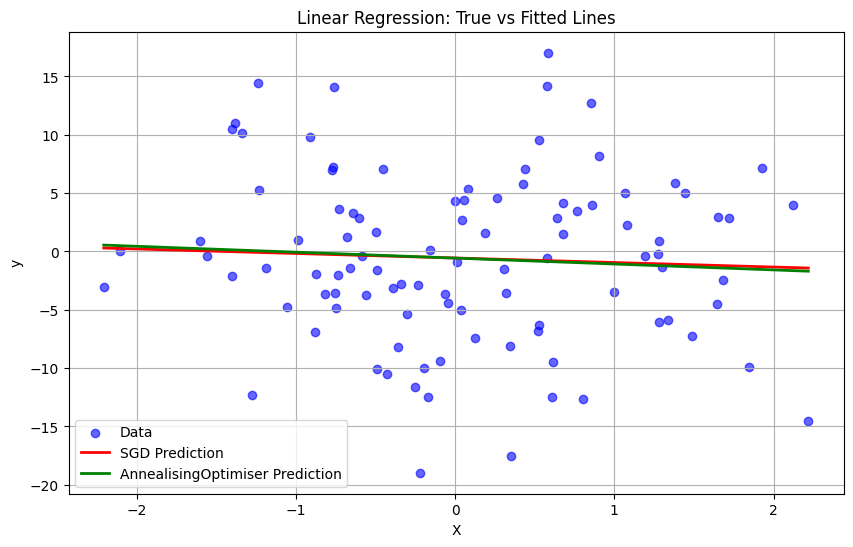

In [ ]:
# Re-import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# True relationship
true_w = 2.0  # True slope
true_b = 0.5  # True intercept
x_line = np.linspace(X.min().item(), X.max().item(), 100)
y_true_line = true_w * x_line + true_b

# SGD fitted line
w_sgd = sgd_params['linear.weight'][0][0]
b_sgd = sgd_params['linear.bias'][0]
y_sgd_line = w_sgd * x_line + b_sgd

# AnnealisingOptimiser fitted line
w_anneal = anneal_params['linear.weight'][0][0]
b_anneal = anneal_params['linear.bias'][0]
y_anneal_line = w_anneal * x_line + b_anneal

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X.detach().cpu().numpy(), y.detach().cpu().numpy(), color='blue', label='Data', alpha=0.6)
plt.plot(x_line, y_sgd_line, color='red', label='SGD Prediction', linewidth=2)
plt.plot(x_line, y_anneal_line, color='green', label='AnnealisingOptimiser Prediction',linewidth=2)
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression: True vs Fitted Lines')
plt.legend()
plt.grid(True)
plt.show()


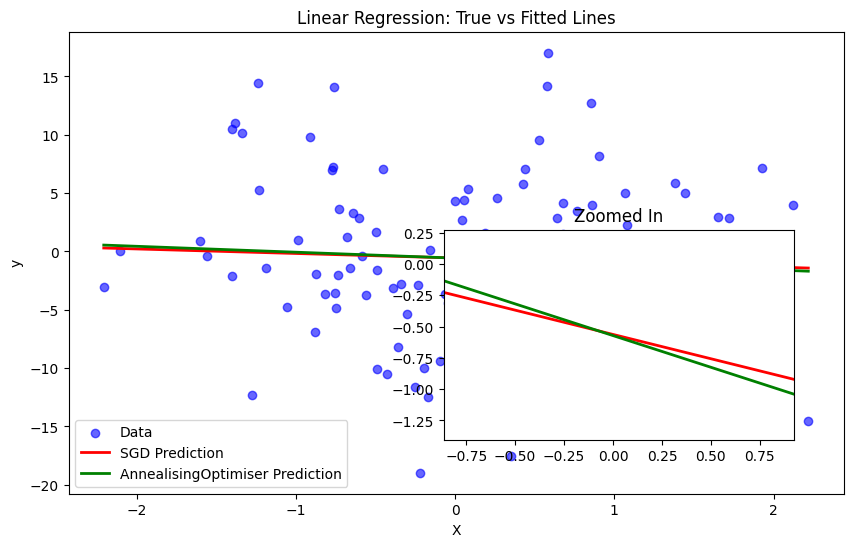

In [ ]:
# Re-import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# True relationship
true_w = 2.0  # True slope
true_b = 0.5  # True intercept
x_line = np.linspace(X.min().item(), X.max().item(), 100)
y_true_line = true_w * x_line + true_b

# SGD fitted line
w_sgd = sgd_params['linear.weight'][0][0]
b_sgd = sgd_params['linear.bias'][0]
y_sgd_line = w_sgd * x_line + b_sgd

# AnnealisingOptimiser fitted line
w_anneal = anneal_params['linear.weight'][0][0]
b_anneal = anneal_params['linear.bias'][0]
y_anneal_line = w_anneal * x_line + b_anneal

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Main plot
ax.scatter(X.detach().cpu().numpy(), y.detach().cpu().numpy(), color='blue', label='Data', alpha=0.6)
ax.plot(x_line, y_sgd_line, color='red', label='SGD Prediction', linewidth=2)
ax.plot(x_line, y_anneal_line, color='green', label='AnnealisingOptimiser Prediction', linewidth=2)
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.set_title('Linear Regression: True vs Fitted Lines')
ax.legend()

# Inset zoom plot
zoom_start, zoom_end = x_line[30], x_line[70]  # Zoom range
ax_inset = fig.add_axes([0.5, 0.2, 0.35, 0.35])  # [left, bottom, width, height]
ax_inset.plot(x_line, y_sgd_line, color='red', label='SGD Prediction', linewidth=2)
ax_inset.plot(x_line, y_anneal_line, color='green', label='AnnealisingOptimiser', linewidth=2)
ax_inset.set_xlim(zoom_start, zoom_end)
ax_inset.set_ylim(min(y_sgd_line[30:70]) - 0.5, max(y_sgd_line[30:70]) + 0.5)
ax_inset.set_title('Zoomed In')

plt.savefig('linear_regression_comparison.pdf', format='pdf', bbox_inches='tight')
plt.show()


## Convergence Speed

Measuring convergence for SGD...
Measuring convergence for AnnealisingOptimiser...


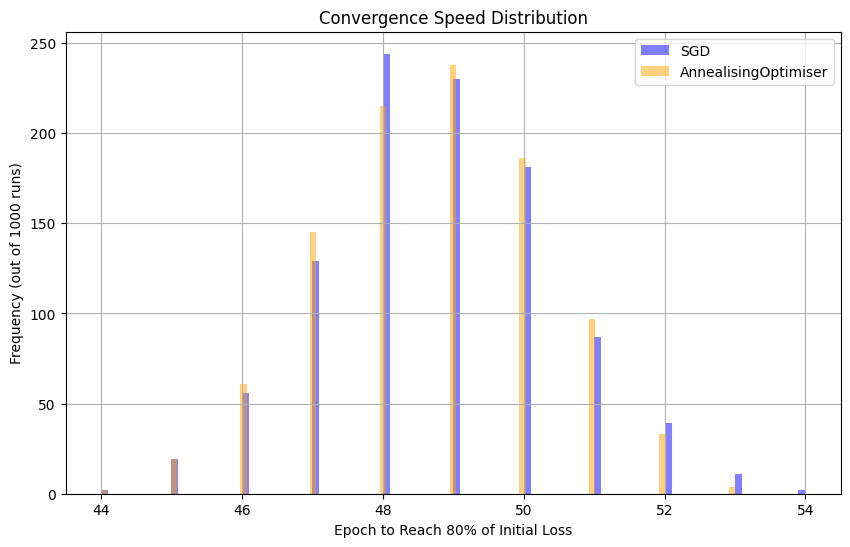

SGD average epochs to converge: 48.77
AnnealisingOptimiser average epochs to converge: 48.72


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable

# -----------------------------
# AnnealisingOptimiser Definition
# -----------------------------
CLIP = 5
FEATURES = 1000
NOISE = 8.6

class AnnealisingOptimiser(optim.Optimizer):
    """
    A heavy-tailed optimizer that uses a fixed, non-adaptive update.
    The stability parameter alpha increases on each step according to:
         alpha = 2 - exp(- (1/5)*step)
    Noise variance decays with the number of steps.
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 alpha=1.2,  # initial value; will be updated each step
                 rho=0.05,
                 decay=0.95,
                 noise_init=0.001,
                 noise_decay=0.55,
                 weight_decay=0,
                 **kwargs):

        defaults = dict(
            lr=lr,
            alpha=alpha,
            rho=rho,
            weight_decay=weight_decay
        )
        super(AnnealisingOptimiser, self).__init__(params, defaults)

        self.decay = decay
        self.noise_init = noise_init
        self.noise_decay = noise_decay
        self.beta = 0  # symmetric noise (beta = 0)
        self.num_steps = 1  # count of updates (for alpha update)
        self.current_sigma = noise_init  # current noise scale
        self.epoch = 0  # epoch counter for potential usage

    def update_epoch(self):
        self.epoch += 1

    @torch.no_grad()
    def step(self, closure=None):
        if closure is None:
            raise ValueError("Requires closure for loss computation")
        closure = torch.enable_grad()(closure)
        loss = closure()

        # Update alpha according to: alpha = 2 - exp(- (1/5)*step)
        self.alpha = 2 - math.exp(- (1 / 5) * self.num_steps)

        # Noise scale decay with step count:
        self.current_sigma = self.noise_init # / ((1 + self.num_steps) ** self.noise_decay)

        # Generate heavy-tailed noise for all parameters.
        total_elems = sum(p.numel() for group in self.param_groups for p in group['params'])
        big_noise = levy_stable.rvs(self.alpha, self.beta, scale=self.current_sigma, size=total_elems)
        np.clip(big_noise, -CLIP, CLIP, out=big_noise)  # clip noise to [-10, 10]

        device = self.param_groups[0]['params'][0].device
        big_noise = torch.from_numpy(big_noise).float().to(device=device)

        idx_start = 0
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                # Optional weight decay
                if group['weight_decay'] != 0:
                    p.grad.data.add_(p.data, alpha=group['weight_decay'])

                elem_count = p.numel()
                noise_slice = big_noise[idx_start:idx_start + elem_count].view_as(p.data)
                idx_start += elem_count

                # Gradient step
                p.data.add_(p.grad.data, alpha=-lr)

                # Heavy-tailed noise step
                noise_coeff = (lr ** (1 / self.alpha)) * noise_slice
                p.data.add_(noise_coeff)

        self.num_steps += 1
        return loss.item()


# -----------------------------
# Synthetic Data + Model
# -----------------------------
def create_dataset(n_samples=100, n_features=FEATURES, noise_std=5.0):
    """
    Creates synthetic linear data: y = X * w + b + noise.
    - w is random ~ Normal(0,2)
    - b = 0.5
    """
    X = torch.randn(n_samples, n_features)  # Feature values
    true_w = torch.randn(n_features, 1) * 2.0  # Random weights
    true_b = 0.5
    noise = torch.randn(n_samples, 1) * noise_std  # Gaussian noise
    y = X.mm(true_w) + true_b + noise  # Adding noise
    return X, y

class LinearRegressionModel(nn.Module):
    def __init__(self, n_features=1):
        super().__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)


# -----------------------------
# Helper: Single-run training
# -----------------------------
def train_until_threshold(model, optimizer, X, y, threshold_loss, max_epochs=100):
    """
    Trains the given model until the MSE loss is below `threshold_loss`
    or until `max_epochs` is reached.
    Returns the epoch at which threshold was reached.
    """

    criterion = nn.MSELoss()

    for epoch in range(1, max_epochs + 1):
        if isinstance(optimizer, AnnealisingOptimiser):
            # The custom optimizer requires a closure:
            def closure():
                optimizer.zero_grad()
                outputs = model(X)
                loss = criterion(outputs, y)
                loss.backward()
                return loss

            loss_val = optimizer.step(closure)
            optimizer.update_epoch()
        else:
            # Standard optimizer (e.g. SGD)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            loss_val = loss.item()

        # Check if we've reached threshold
        if loss_val < threshold_loss:
            return epoch

    return max_epochs  # If not reached threshold within max_epochs


# -----------------------------
# Main experiment function
# -----------------------------
def measure_convergence_steps(optimizer_type='sgd',
                              n_trials=1000,
                              threshold_factor=0.5,
                              max_epochs=100):
    """
    Runs `n_trials` independent experiments of training a linear regression model
    on a freshly generated dataset each time. Returns a list of epochs it took
    to reach `threshold_factor * (initial loss)`.
    """
    steps_to_converge = []

    for trial in range(n_trials):
        # 1. Create data
        X, y = create_dataset(n_samples=1000, n_features=FEATURES, noise_std=NOISE)

        # 2. Initialize model
        model = LinearRegressionModel(n_features=FEATURES)

        # 3. Compute the *initial* MSE loss (before any training)
        with torch.no_grad():
            outputs = model(X)
            init_loss = nn.MSELoss()(outputs, y).item()

        # 4. Set the threshold
        target_loss = threshold_factor * init_loss

        # 5. Create the optimizer
        if optimizer_type == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=0.001)
        elif optimizer_type == 'anneal':
            optimizer = AnnealisingOptimiser(model.parameters(), lr=0.001, noise_init=0.1, noise_decay=0.55)
        else:
            raise ValueError("Unknown optimizer type")

        # 6. Train until threshold or max_epochs
        steps = train_until_threshold(model, optimizer, X, y,
                                      threshold_loss=target_loss,
                                      max_epochs=max_epochs)
        steps_to_converge.append(steps)

    return steps_to_converge


# -----------------------------
# Run 1000 Trials + Plot
# -----------------------------

n_trials = 1000
max_epochs = 100

print("Measuring convergence for SGD...")
sgd_steps = measure_convergence_steps(optimizer_type='sgd',
                                      n_trials=n_trials,
                                      threshold_factor=0.7,
                                      max_epochs=max_epochs)

print("Measuring convergence for AnnealisingOptimiser...")
anneal_steps = measure_convergence_steps(optimizer_type='anneal',
                                          n_trials=n_trials,
                                          threshold_factor=0.7,
                                          max_epochs=max_epochs)

# -----------------------------
# Plot the distributions
# -----------------------------
plt.figure(figsize=(10, 6))
plt.hist(sgd_steps, bins=10, alpha=0.5, label='SGD', color='blue')
plt.hist(anneal_steps, bins=10, alpha=0.5, label='AHTSGD', color='orange')
plt.xlabel("Epoch to Reach 40% of Initial Loss")
plt.ylabel("Frequency (out of 1000 runs)")
plt.title("Convergence Speed Distribution")
plt.legend()
plt.grid(False)
plt.savefig("convergence_speed_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Optional: Print average epochs
print(f"SGD average epochs to converge: {np.mean(sgd_steps):.2f}")
print(f"AnnealisingOptimiser average epochs to converge: {np.mean(anneal_steps):.2f}")

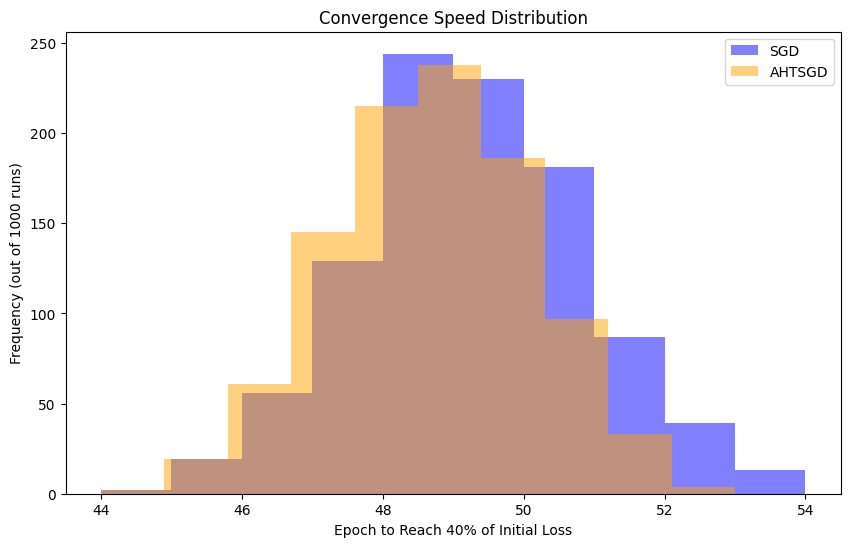

SGD average epochs to converge: 48.77
AnnealisingOptimiser average epochs to converge: 48.72


In [ ]:
# -----------------------------
plt.figure(figsize=(10, 6))
plt.hist(sgd_steps, bins=10, alpha=0.5, label='SGD', color='blue')
plt.hist(anneal_steps, bins=10, alpha=0.5, label='AHTSGD', color='orange')
plt.xlabel("Epoch to Reach 40% of Initial Loss")
plt.ylabel("Frequency (out of 1000 runs)")
plt.title("Convergence Speed Distribution")
plt.legend()
plt.grid(False)
plt.savefig("convergence_speed_distribution.pdf", format='pdf', bbox_inches='tight')
plt.show()

# Optional: Print average epochs
print(f"SGD average epochs to converge: {np.mean(sgd_steps):.2f}")
print(f"AnnealisingOptimiser average epochs to converge: {np.mean(anneal_steps):.2f}")